ET DEEP LEARNING

# <img style="float: left; padding-right: 20px; width: 100px" src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*gd5Wd-OtKVQvP9XAOX7vGg.png">

#Mineria de datos
**Duoc UC**<br>
https://www.ibm.com/docs/es/spss-modeler/saas?topic=dm-crisp-help-overview


In [ ]:
# Cargar Tiny ImageNet desde TFDS personalizado
!pip install git+https://github.com/ksachdeva/tiny-imagenet-tfds.git


  Cloning https://github.com/ksachdeva/tiny-imagenet-tfds.git to /tmp/pip-req-build-3x_7bvkh
  Running command git clone --filter=blob:none --quiet https://github.com/ksachdeva/tiny-imagenet-tfds.git /tmp/pip-req-build-3x_7bvkh
  Resolved https://github.com/ksachdeva/tiny-imagenet-tfds.git to commit 8dbaaf62f3806e5ad8a95c980061575851c442e6
  Preparing metadata (setup.py) ... done
  Created wheel for tiny-imagenet-tfds: filename=tiny_imagenet_tfds-0.1.0-py3-none-any.whl size=7807 sha256=e0f4279e7d954d5e0c609b70b9ea47353d188854c731b62c83991c92d3cefe5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-lvr9pagp/wheels/be/46/88/d7158790ef358ceb10e82fe5f15cebd3afcc28c9f5cef243c1
Successfully built tiny-imagenet-tfds


In [ ]:
# Descargar y preparar Tiny ImageNet
import os

# Descargar y descomprimir si no existe
if not os.path.exists("tiny-imagenet-200"):
    import urllib.request, zipfile
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    urllib.request.urlretrieve(url, "tiny-imagenet-200.zip")
    with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as zip_ref:
        zip_ref.extractall(".")


In [ ]:
#Cargar Tiny ImageNet desde directorios
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import shutil
import pandas as pd

In [ ]:
# Ruta local al dataset descomprimido
dataset_dir = "tiny-imagenet-200"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val", "images")

In [ ]:
# Reorganizar val/imagenes a subdirectorios por clase si es necesario
annotations_path = os.path.join(dataset_dir, "val", "val_annotations.txt")
df = pd.read_csv(annotations_path, sep='\t', header=None)
df.columns = ["image", "label", "x1", "y1", "x2", "y2"]

val_class_dir = os.path.join(dataset_dir, "val", "organized")
os.makedirs(val_class_dir, exist_ok=True)

for _, row in df.iterrows():
    label_dir = os.path.join(val_class_dir, row["label"])
    os.makedirs(label_dir, exist_ok=True)
    src = os.path.join(val_dir, row["image"])
    dst = os.path.join(label_dir, row["image"])
    if os.path.exists(src):
        shutil.copy(src, dst)

In [ ]:
# Cargar datasets con image_dataset_from_directory
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode="int"
)

val_ds = image_dataset_from_directory(
    val_class_dir,
    image_size=(224, 224),
    batch_size=64,
    label_mode="int"
)

Found 100000 files belonging to 200 classes.
Found 10000 files belonging to 200 classes.


In [ ]:
# Normalizar imágenes UNA SOLA VEZ EJECUTAR
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)


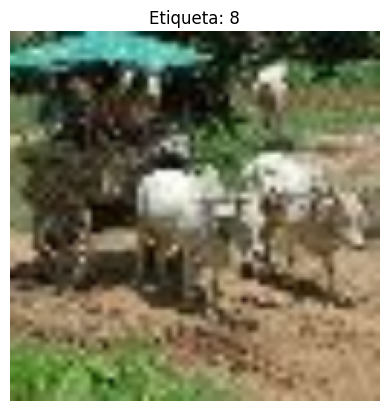

In [ ]:
# Mostrar una imagen de ejemplo
for images, labels in train_ds.take(1):
    import matplotlib.pyplot as plt
    plt.imshow(images[6].numpy())
    plt.title(f"Etiqueta: {labels[0].numpy()}")
    plt.axis('off')
    plt.show()


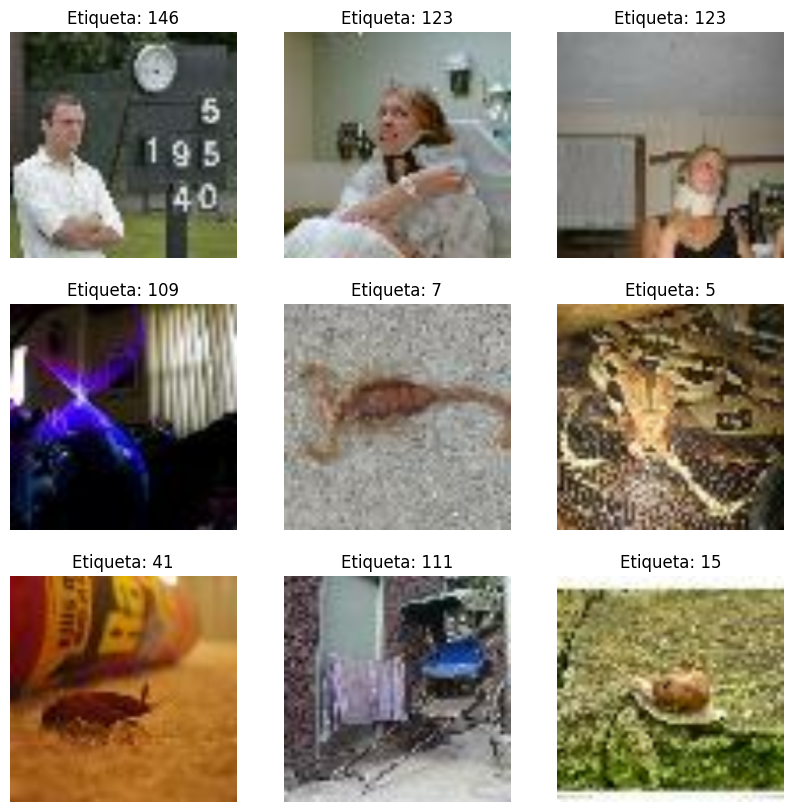

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Etiqueta: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()


In [ ]:
for images, labels in train_ds.take(1):
    print("Forma:", images[0].shape)
    print("Valor mínimo:", tf.reduce_min(images[0]).numpy())
    print("Valor máximo:", tf.reduce_max(images[0]).numpy())



Forma: (224, 224, 3)
Valor mínimo: 0.0
Valor máximo: 254.97958


In [ ]:


# 1. Bloque de Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

# 2. Base ResNet50 preentrenada (sin top)
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
# Congelar las primeras capas, liberar solo las últimas
for layer in base_model.layers[:-50]:
    layer.trainable = False

# 3. Armado del modelo completo
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(200, activation='softmax')(x)

resnet_model = tf.keras.Model(inputs, outputs)

# 4. Compilar modelo
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extraer etiquetas reales desde train_ds
y_train = []
for _, label in train_ds.unbatch():
    y_train.append(label.numpy())

y_train = np.array(y_train)
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

In [ ]:


# 5. Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("resnet_tinyimagenet.keras", monitor='val_accuracy', save_best_only=True)

# 6. Entrenamiento inicial (solo la cabeza)
history1 = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 116s 74ms/step - accuracy: 0.5662 - loss: 1.7418 - val_accuracy: 0.5972 - val_loss: 1.6625 - learning_rate: 5.0000e-04
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 114s 73ms/step - accuracy: 0.5778 - loss: 1.6983 - val_accuracy: 0.5913 - val_loss: 1.7052 - learning_rate: 5.0000e-04
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 116s 74ms/step - accuracy: 0.5894 - loss: 1.6365 - val_accuracy: 0.5981 - val_loss: 1.6479 - learning_rate: 5.0000e-04
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 115s 74ms/step - accuracy: 0.5893 - loss: 1.6398 - val_accuracy: 0.6038 - val_loss: 1.6615 - learning_rate: 5.0000e-04
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 115s 74ms/step - accuracy: 0.6031 - loss: 1.5839 - val_accuracy: 0.6140 - val_loss: 1.6177 - learning_rate: 5.0000e-04
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 115s 74ms/step - accuracy: 0.6074 - loss: 1.5530 - val_accuracy: 0.6143 - val_loss: 1.6250 - learning_rate: 5.0000e-04
Epoch 7/10
1562/1563 ━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true, y_pred = [], []
for images, labels in val_ds:
    preds = resnet_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

report = classification_report(y_true, y_pred, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.9216    0.9400    0.9307        50
           1     0.8077    0.8400    0.8235        50
           2     0.6102    0.7200    0.6606        50
           3     0.6970    0.4600    0.5542        50
           4     0.6415    0.6800    0.6602        50
           5     0.5435    0.5000    0.5208        50
           6     0.9111    0.8200    0.8632        50
           7     0.6667    0.5200    0.5843        50
           8     0.8723    0.8200    0.8454        50
           9     0.7500    0.6000    0.6667        50
          10     0.7000    0.7000    0.7000        50
          11     0.7255    0.7400    0.7327        50
          12     0.8235    0.8400    0.8317        50
          13     0.7647    0.7800    0.7723        50
          14     0.7907    0.6800    0.7312        50
          15     0.6316    0.4800    0.5455        50
          16     0.5455    0.4800    0.5106        50
          17     0.8444    

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history_obj):
    history = history_obj.history
    epochs = range(len(history['loss']))

    plt.figure(figsize=(14, 5))

    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Val Accuracy')
    plt.title('Precisión por época')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy

#  Solo libero las últimas capas de ResNet
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompilar con menor LR para evitar sobreajuste
from tensorflow.keras import metrics


resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=[
        SparseCategoricalAccuracy(name='accuracy'),
        SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')
    ]
)


In [ ]:
# 8. Segundo entrenamiento (fine-tuning total)
history2 = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    initial_epoch=10,  # para continuar desde la epoch 10
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

Epoch 11/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 136s 76ms/step - accuracy: 0.6712 - loss: 1.2669 - top_5_accuracy: 0.8720 - val_accuracy: 0.6318 - val_loss: 1.5724 - val_top_5_accuracy: 0.8369 - learning_rate: 1.0000e-05
Epoch 12/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 117s 75ms/step - accuracy: 0.6768 - loss: 1.2535 - top_5_accuracy: 0.8737 - val_accuracy: 0.6328 - val_loss: 1.5676 - val_top_5_accuracy: 0.8379 - learning_rate: 1.0000e-05
Epoch 13/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 117s 75ms/step - accuracy: 0.6777 - loss: 1.2461 - top_5_accuracy: 0.8748 - val_accuracy: 0.6345 - val_loss: 1.5677 - val_top_5_accuracy: 0.8378 - learning_rate: 1.0000e-05
Epoch 14/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 117s 75ms/step - accuracy: 0.6793 - loss: 1.2333 - top_5_accuracy: 0.8762 - val_accuracy: 0.6346 - val_loss: 1.5654 - val_top_5_accuracy: 0.8389 - learning_rate: 1.0000e-05
Epoch 15/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 117s 75ms/step - accuracy: 0.6825 - loss: 1.2318 - top_5_accuracy: 0.8761 - val_accuracy: 0.6

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true, y_pred = [], []
for images, labels in val_ds:
    preds = resnet_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

report = classification_report(y_true, y_pred, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.9231    0.9600    0.9412        50
           1     0.8571    0.8400    0.8485        50
           2     0.6000    0.6000    0.6000        50
           3     0.5870    0.5400    0.5625        50
           4     0.6667    0.7200    0.6923        50
           5     0.5625    0.5400    0.5510        50
           6     0.8542    0.8200    0.8367        50
           7     0.5854    0.4800    0.5275        50
           8     0.8913    0.8200    0.8542        50
           9     0.6889    0.6200    0.6526        50
          10     0.7727    0.6800    0.7234        50
          11     0.8000    0.7200    0.7579        50
          12     0.8400    0.8400    0.8400        50
          13     0.7843    0.8000    0.7921        50
          14     0.7451    0.7600    0.7525        50
          15     0.5750    0.4600    0.5111        50
          16     0.5610    0.4600    0.5055        50
          17     0.8478    

In [ ]:
import matplotlib.pyplot as plt

def plot_combined_history(history1, history2):
    # Combinar las métricas
    combined = {}
    for key in history1.history.keys():
        combined[key] = history1.history[key] + history2.history[key]

    epochs = range(len(combined['loss']))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, combined['accuracy'], label='Train Accuracy')
    plt.plot(epochs, combined['val_accuracy'], label='Val Accuracy')
    plt.title('Precisión por época')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, combined['loss'], label='Train Loss')
    plt.plot(epochs, combined['val_loss'], label='Val Loss')
    plt.title('Pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


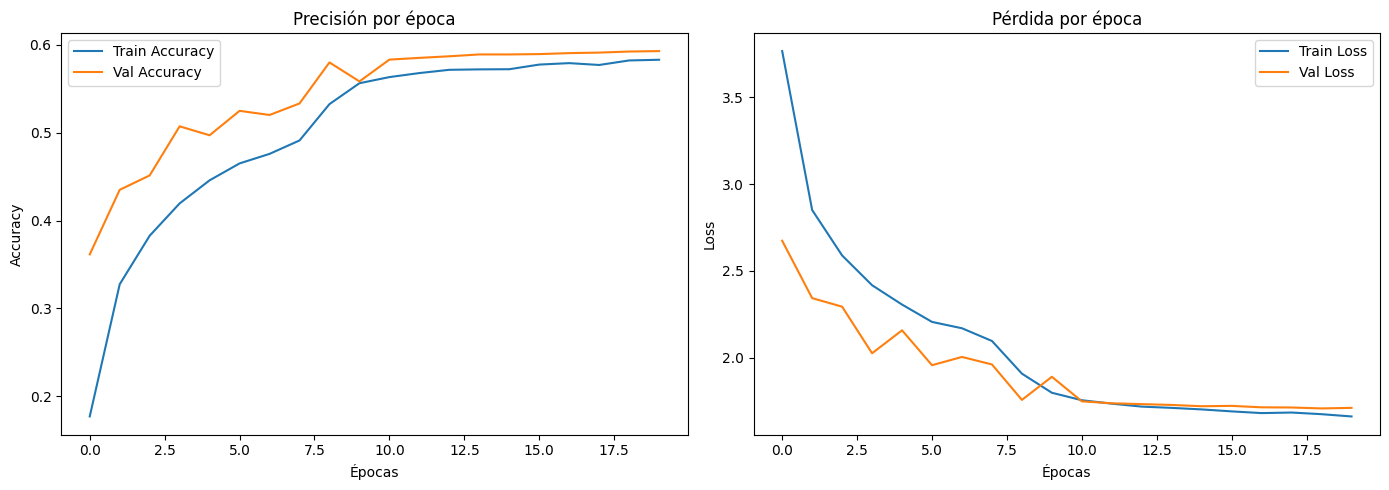

In [ ]:
plot_combined_history(history1, history2)


In [ ]:
# 8. Tercer entrenamiento (fine-tuning total)
history3 = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    initial_epoch=20,  # para continuar desde la epoch 20
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)

Epoch 21/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 116s 74ms/step - accuracy: 0.6876 - loss: 1.2090 - top_5_accuracy: 0.8806 - val_accuracy: 0.6347 - val_loss: 1.5608 - val_top_5_accuracy: 0.8402 - learning_rate: 5.0000e-06
Epoch 22/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 115s 74ms/step - accuracy: 0.6848 - loss: 1.2109 - top_5_accuracy: 0.8801 - val_accuracy: 0.6350 - val_loss: 1.5616 - val_top_5_accuracy: 0.8402 - learning_rate: 5.0000e-06
Epoch 23/30
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6846 - loss: 1.2135 - top_5_accuracy: 0.8799
Epoch 23: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 115s 74ms/step - accuracy: 0.6846 - loss: 1.2134 - top_5_accuracy: 0.8799 - val_accuracy: 0.6359 - val_loss: 1.5631 - val_top_5_accuracy: 0.8397 - learning_rate: 5.0000e-06
Epoch 24/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 115s 74ms/step - accuracy: 0.6863 - loss: 1.2022 - top_5_accuracy: 0.8810 - val_accuracy: 0.6352 - val_loss: 1.5590 - val_top_5_a

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true, y_pred = [], []
for images, labels in val_ds:
    preds = resnet_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

report = classification_report(y_true, y_pred, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.9057    0.9600    0.9320        50
           1     0.8400    0.8400    0.8400        50
           2     0.6250    0.6000    0.6122        50
           3     0.5532    0.5200    0.5361        50
           4     0.6481    0.7000    0.6731        50
           5     0.5510    0.5400    0.5455        50
           6     0.8367    0.8200    0.8283        50
           7     0.5682    0.5000    0.5319        50
           8     0.8913    0.8200    0.8542        50
           9     0.6889    0.6200    0.6526        50
          10     0.7674    0.6600    0.7097        50
          11     0.8000    0.7200    0.7579        50
          12     0.8400    0.8400    0.8400        50
          13     0.7843    0.8000    0.7921        50
          14     0.7800    0.7800    0.7800        50
          15     0.5750    0.4600    0.5111        50
          16     0.5476    0.4600    0.5000        50
          17     0.8478    

In [ ]:
import matplotlib.pyplot as plt

def plot_combined_history(history1, history2,history3):
    # Combinar las métricas
    combined = {}
    for key in history1.history.keys():
        combined[key] = history1.history[key] + history2.history[key] + history3.history[key]

    epochs = range(len(combined['loss']))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, combined['accuracy'], label='Train Accuracy')
    plt.plot(epochs, combined['val_accuracy'], label='Val Accuracy')
    plt.title('Precisión por época')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, combined['loss'], label='Train Loss')
    plt.plot(epochs, combined['val_loss'], label='Val Loss')
    plt.title('Pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


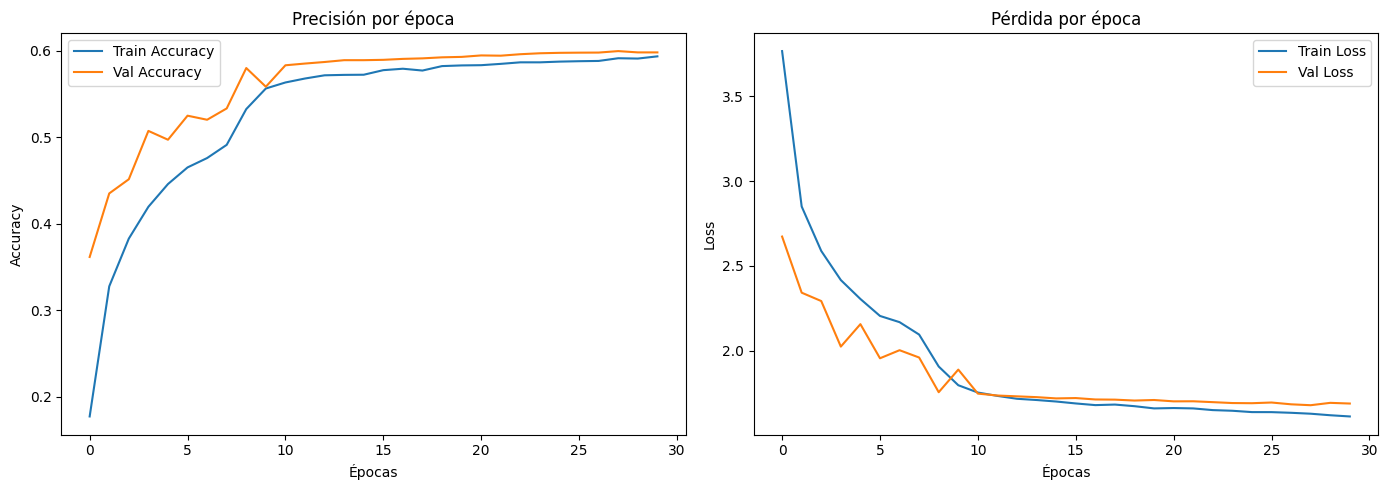

In [ ]:
plot_combined_history(history1, history2, history3)


In [ ]:
history4 = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    initial_epoch=30,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)


Epoch 31/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 116s 74ms/step - accuracy: 0.6856 - loss: 1.2066 - top_5_accuracy: 0.8786 - val_accuracy: 0.6345 - val_loss: 1.5611 - val_top_5_accuracy: 0.8399 - learning_rate: 2.5000e-06
Epoch 32/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 116s 74ms/step - accuracy: 0.6874 - loss: 1.2146 - top_5_accuracy: 0.8772 - val_accuracy: 0.6348 - val_loss: 1.5604 - val_top_5_accuracy: 0.8396 - learning_rate: 2.5000e-06
Epoch 33/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 116s 74ms/step - accuracy: 0.6877 - loss: 1.1990 - top_5_accuracy: 0.8809 - val_accuracy: 0.6357 - val_loss: 1.5611 - val_top_5_accuracy: 0.8396 - learning_rate: 2.5000e-06
Epoch 34/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 115s 74ms/step - accuracy: 0.6877 - loss: 1.2036 - top_5_accuracy: 0.8804 - val_accuracy: 0.6359 - val_loss: 1.5591 - val_top_5_accuracy: 0.8396 - learning_rate: 2.5000e-06
Epoch 35/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 115s 74ms/step - accuracy: 0.6880 - loss: 1.2043 - top_5_accuracy: 0.8803 - val_accuracy: 0.6

In [ ]:
import matplotlib.pyplot as plt

def plot_combined_history(history1, history2,history3, history4):
    # Combinar las métricas
    combined = {}
    for key in history1.history.keys():
        combined[key] = history1.history[key] + history2.history[key] + history3.history[key] + history4.history[key]

    epochs = range(len(combined['loss']))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, combined['accuracy'], label='Train Accuracy')
    plt.plot(epochs, combined['val_accuracy'], label='Val Accuracy')
    plt.title('Precisión por época')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, combined['loss'], label='Train Loss')
    plt.plot(epochs, combined['val_loss'], label='Val Loss')
    plt.title('Pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_true, y_pred = [], []
for images, labels in val_ds:
    preds = resnet_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

report = classification_report(y_true, y_pred, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.9057    0.9600    0.9320        50
           1     0.8400    0.8400    0.8400        50
           2     0.6170    0.5800    0.5979        50
           3     0.5652    0.5200    0.5417        50
           4     0.6481    0.7000    0.6731        50
           5     0.5400    0.5400    0.5400        50
           6     0.8367    0.8200    0.8283        50
           7     0.5909    0.5200    0.5532        50
           8     0.8723    0.8200    0.8454        50
           9     0.7045    0.6200    0.6596        50
          10     0.7674    0.6600    0.7097        50
          11     0.8000    0.7200    0.7579        50
          12     0.8400    0.8400    0.8400        50
          13     0.7843    0.8000    0.7921        50
          14     0.7708    0.7400    0.7551        50
          15     0.5714    0.4800    0.5217        50
          16     0.5610    0.4600    0.5055        50
          17     0.8478    

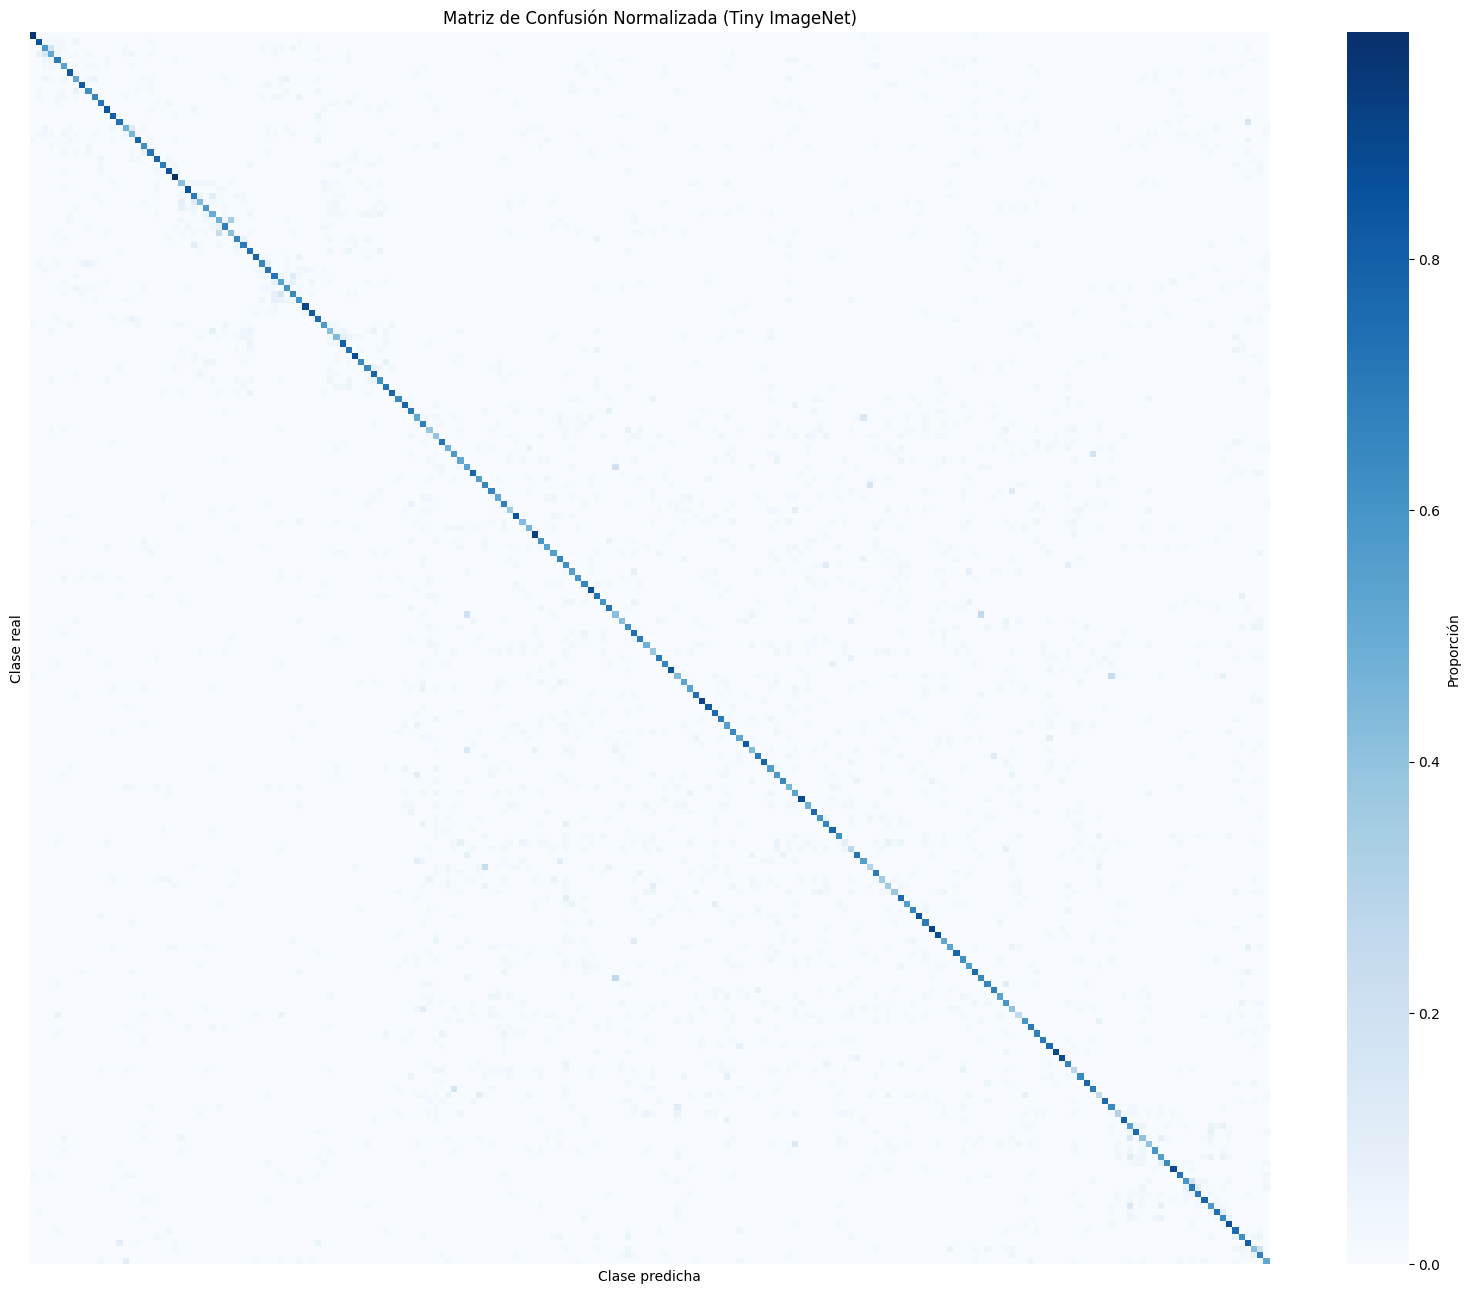

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Asegurate de tener y_true y y_pred como listas de etiquetas
cm = confusion_matrix(y_true, y_pred, labels=range(200))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalizada por fila

plt.figure(figsize=(20, 16))
sns.heatmap(cm_norm, cmap="Blues", square=False,
            xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Proporción'})
plt.title("Matriz de Confusión Normalizada (Tiny ImageNet)")
plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Obtener el reporte como diccionario
report_dict = classification_report(y_true, y_pred, output_dict=True)

# Convertir a DataFrame
df_report = pd.DataFrame(report_dict).transpose()

# Filtrar solo las filas que son clases numéricas
df_clases = df_report[df_report.index.str.isnumeric()]

# Ordenar por recall ascendente (menor a mayor)
peor_recall = df_clases.sort_values(by='recall').head(10)

print(peor_recall[['precision', 'recall', 'f1-score']])


     precision  recall  f1-score
131   0.250000    0.10  0.142857
159   0.419355    0.26  0.320988
172   0.361111    0.26  0.302326
132   0.311111    0.28  0.294737
168   0.325581    0.28  0.301075
175   0.517241    0.30  0.379747
135   0.454545    0.30  0.361446
77    0.391304    0.36  0.375000
138   0.375000    0.36  0.367347
137   0.580645    0.36  0.444444


In [ ]:
def oversample_clases(ds, clases_ids, veces=3):
    # Lista de datasets sobre-replicados
    ds_extra = []
    for clase in clases_ids:
        ds_clase = filtrar_por_clase(ds, clase)
        ds_clase_rep = ds_clase.repeat(veces)
        ds_extra.append(ds_clase_rep)

    # Combinar todas las clases reforzadas
    ds_oversampled = ds_extra[0]
    for ds_add in ds_extra[1:]:
        ds_oversampled = ds_oversampled.concatenate(ds_add)

    return ds_oversampled


In [ ]:
# Clases con bajo recall (ejemplo: clases 131, 175, 159, ...)
clases_a_reforzar = [131, 175, 159, 80, 172, 49, 180, 135, 132, 168]

# Crear dataset con oversampling
ds_oversampled = oversample_clases(train_ds, clases_a_reforzar, veces=3)

# Mezclar todo
train_ds_final = train_ds.concatenate(ds_oversampled).shuffle(10000).batch(64)


# Prototipado con Gradio, para subir foto del set de TEST

In [ ]:
from tensorflow.keras.models import load_model

resnet_model = load_model("resnet_tinyimagenet.keras")


In [ ]:
with open("words200.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]


In [ ]:
def predict_image(image):
    image = image.resize((224, 224))
    image_array = np.array(image).astype(np.float32) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    predictions = resnet_model.predict(image_array)[0]  # <--- usa el nombre correcto
    top_5 = predictions.argsort()[-5:][::-1]
    return {class_names[i]: float(predictions[i]) for i in top_5}


In [ ]:
import gradio as gr

gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=5),
    title="Tiny ImageNet Classifier"
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://36672288efa790493b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
print(len(class_names))


200


In [ ]:
print(resnet_model.evaluate(val_ds))


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6410 - loss: 1.5369 - top_5_accuracy: 0.8424
[1.5560368299484253, 0.636900007724762, 0.8406000137329102]


# Conclusiones